#Preprocessing the ocr text

In [1]:
import pandas as pd
import re

In [5]:
df = pd.read_csv('sample_1000.csv')
ocr = pd.read_csv('sample_1000_ocr.csv')

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)
ocr.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
df['ocr_text'] = ocr['result'].apply(lambda x: ' '.join(eval(x)))

Using Regex to extract substrings with numeric values in them. I am taking a substring made up of 50 characters before and after any numreric character.

In [8]:
pattern = re.compile('.{0,50}\d.{0,50}')
df['reg_text'] = df['ocr_text'].apply(lambda x: ' '.join(re.findall(pattern, x)))

In [9]:
#Droping empty strings
df.drop(df[df['reg_text']==''].index,  inplace=True)

Using Regex to extract shorter which will be used for ByT5 as it is byte based transforemer so long strings will hamper its performance by a big factor. I am taking a substring made up of 2 characters before and 10 after any numreric character.

In [10]:
pattern = re.compile('.{0,2}\d.{0,10}')
df['num_reg_text'] = df['ocr_text'].apply(lambda x: ' '.join(re.findall(pattern, x)))

Modifying the inputs to include asked entity as a prompt

In [11]:
def add_prefix(ser):
  if ser in ['voltage', 'width', 'depth', 'wattage', 'height']:
    prefix = 'extract {}: '.format(ser+' '*(29-len(ser)))
  elif ser == 'item_weight':
    prefix = 'extract {}: '.format('weight'+' '*(29-len('weight')))
  elif ser == 'maximum_weight_recommendation':
    prefix = 'extract {}: '.format('maximum weight recommendation')
  elif ser == 'item_volume':
    prefix = 'extract {}: '.format('volume'+' '*(29-len('volume')))
  return prefix

In [12]:
df['input'] = df['entity_name'].apply(lambda x: add_prefix(x))
df.reset_index(drop=True, inplace=True)

Exploring the length of text inputs which will be later be used for selecting the maximum length of tokenizer.

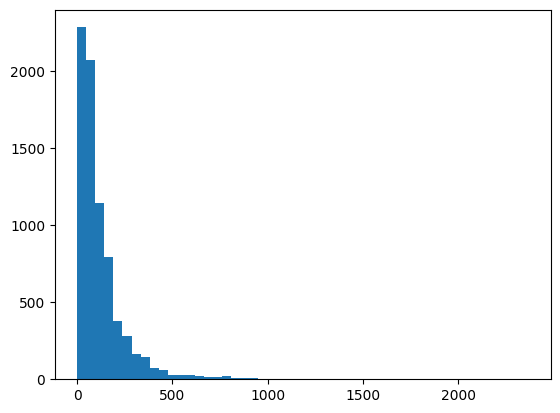

In [18]:
import matplotlib.pyplot as plt
l1 = df['num_reg_text'].apply(lambda x: len(x))
plot = plt.hist(l, bins=50)

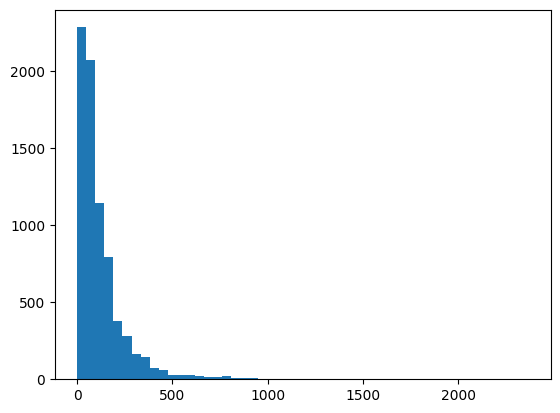

In [19]:
import matplotlib.pyplot as plt
l2 = df['reg_text'].apply(lambda x: len(x))
plot = plt.hist(l, bins=50)

In [21]:
print("## Shorter Numeric Text Lengths ##")
print(pd.Series(l1).describe())

print("## Full Text Lengths ##")
print(pd.Series(l2).describe())

## Shorter Numeric Text Lengths ##
count    7652.000000
mean       56.587297
std        64.264054
min         1.000000
25%        21.000000
50%        38.500000
75%        68.000000
max       934.000000
Name: num_reg_text, dtype: float64
## Full Text Lengths ##
count    7652.000000
mean      128.960141
std       173.107134
min         1.000000
25%        39.000000
50%        81.000000
75%       156.000000
max      2368.000000
Name: reg_text, dtype: float64


200 seems like a good choice for max length of tokenizer

###Saving Files

Input csv file ByT5

In [22]:
byt5_data = pd.DataFrame()
byt5_data['input'] = df['input'] + df['num_reg_text']
byt5_data['target'] = df['entity_value']
byt5_data['id'] = byt5_data.index.astype(str)
byt5_data.to_csv('byt5_data_1000_att.csv', index=False)
byt5_data

,input,target,id
0,extract weight : -Z01OK ...,28.0 kilogram,0
1,extract width : H 11/4 ...,98.0 millimetre,1
2,extract voltage : B023 R...,220.0 volt,2
3,extract depth : 2.48'/6...,25.0 millimetre,3
4,extract weight : 7.5cm u...,200 gram,4
...,...,...,...
7647,extract volume : R 50 SU...,355.0 millilitre,7647
7648,extract maximum weight recommendation: CV21 1P...,225 pound,7648
7649,extract weight : # 18288...,39.4 ounce,7649
7650,extract weight : L87 4....,4.7 pound,7650


Input csv file BART

In [ ]:
bart_data = pd.DataFrame()
bart_data['input'] = df['input'] + df['reg_text']
bart_data['target'] = df['entity_value']
bart_data['id'] = bart_data.index.astype(str)
bart_data.to_csv('bart_data_1000.csv', index=False)
bart_data

,input,target,id
0,extract weight: FBA ITEM NO:LD-Z01OK XO SIZE:1...,28.0 kilogram,0
1,extract width: urite sizes of cones ONE SIZE F...,98.0 millimetre,1
2,extract voltage: LED Ceiling Lamp Model B023 R...,220.0 volt,2
3,extract depth: 2.48'/63mm 0.98inch/25mm M4 1.9...,25.0 millimetre,3
4,extract weight: 7.5cm urban platter Classic So...,200 gram,4
...,...,...,...
7647,extract volume: AB SANS ALCOU BUDWEISER Budwei...,355.0 millilitre,7647
7648,extract maximum weight recommendation: Add.: U...,225 pound,7648
7649,extract weight: MODEL# 182883 BX-4 Range HD TB...,39.4 ounce,7649
7650,extract weight: ING L87 4.7 4.2TO PU5000ING L8...,4.7 pound,7650


#Loading Dataset

Installing and importing huggingface datasets and hub library

In [23]:
!pip install datasets==2.15.0
!pip install huggingface_hub==0.25.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2023.10.0 which is incompatible.
   ━━━━━━━━━━━━━━━━

In [24]:
import pandas as pd
import torch

In [25]:
data = pd.read_csv('byt5_data_1000_att.csv') #add the input file based on your transformer

In [26]:
from datasets import Dataset, load_metric

dataset = Dataset.from_pandas(data)
dataset

Dataset({
    features: ['input', 'target', 'id'],
    num_rows: 7652
})

In [27]:
data = dataset.shuffle(seed=42).select(range(7652))
split = data.train_test_split(seed=42, test_size=0.2)
split["test"][0], split["train"][0]

({'input': 'extract width                        : S 60.94MX30.4 h 60.94 QUICK',
  'target': '30.4 centimetre',
  'id': 400},
 {'input': 'extract depth                        : . 50mm 2.65mm  4.5mm',
  'target': '50.0 millimetre',
  'id': 551})

#Tokenization

In [28]:
max_len = 200
stride = 1

In [29]:
#Modifying the attention to make the asked entity token more important
def modify_attention_mask(tokenized_input, entity_len):
    for i in range(len(entity_len)):
        e = entity_len[i]
        seq_length = len(tokenized_input['attention_mask'][i])
        custom_attention_mask = torch.tensor([0]*8+ [1]*e + [0]*(30-e) + [0.9]*(seq_length-38))
        tokenized_input['attention_mask'][i] = custom_attention_mask*tokenized_input['attention_mask'][i]
    return tokenized_input['attention_mask']

In [38]:
def s2s_tokenizer(batch):
    input =  [x for x in batch['input']]
    target = [x for x in batch['target']]
    entity_len = [len(x[8:37].rstrip()) for x in batch['input']]

    tokenized_input = tokenizer(
                                input,
                                max_length=max_len,
                                return_tensors = 'pt',
                                truncation=True,
                                stride = stride,
                                padding = 'max_length'
                                )
    ################ Comment these if you want to use default attention masks ######################
    tokenized_input['attention_mask'] = tokenized_input['attention_mask'].float()
    tokenized_input['attention_mask'] = modify_attention_mask(tokenized_input, entity_len)
    ##################### For BART default attention masks were used ###############################

    tokenized_targets = tokenizer(
                                target,
                                max_length=max_len,
                                truncation=True,
                                stride = stride,
                                padding = 'max_length'
                                )

    tokenizer_full = tokenized_input.copy()
    tokenizer_full['labels'] = tokenized_targets['input_ids']
    return tokenizer_full

###BART Tokenizer

In [9]:
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


###ByT5 Tokenizer

In [31]:
from transformers import ByT5Tokenizer
tokenizer = ByT5Tokenizer.from_pretrained("google/byt5-small",
                                        safe_serialization=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


###Tokenizing the Dataset

In [39]:
tokenized_datasets = split.map(
                            s2s_tokenizer,
                            batched=True,
                            remove_columns=split['train'].column_names,
                            )

Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

Map:   0%|          | 0/1531 [00:00<?, ? examples/s]

In [40]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6121
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1531
    })
})

In [41]:
tokenized_input = tokenized_datasets['train'][0]
torch.tensor(tokenized_input['attention_mask'])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [15]:
tokenizer.decode(torch.tensor(tokenized_datasets['train'][0]['input_ids']), skip_special_tokens=True), split['train'][0]['input']

('extract depth                        :. 50mm 2.65mm  4.5mm',
 'extract depth                        : . 50mm 2.65mm  4.5mm')

#Evaluation Metrics

In [49]:
!pip install sacrebleu
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00


In [50]:
import numpy as np
import torch

In [51]:
def compute_metrics(
                    preds_and_labels,
                    bleu_metric = load_metric("sacrebleu"),
                    bert_metric = load_metric("bertscore")
                    ):

    preds, labels = preds_and_labels
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # for any -100 label, replace with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # convert labels into words
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu = bleu_metric.compute(
                                predictions=decoded_preds,
                                references=decoded_labels
                                )
    bert_score = bert_metric.compute(
                                    predictions=decoded_preds,
                                    references=decoded_labels,
                                    lang='fr'
                                    )
    exact_match_score = (np.array(decoded_preds) == np.array(decoded_labels)).mean()

    return {
            "bleu": bleu["score"],
            'bert_score': np.mean(bert_score['f1']),
            'exact_match_score': exact_match_score
            }

<ipython-input-51-6baf5f6dac04>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu"),


#Fine-Tuning

In [19]:
from huggingface_hub import notebook_login
notebook_login()

###BART

In [15]:
from transformers import BartForConditionalGeneration
bart_model = BartForConditionalGeneration.from_pretrained("Utkash/finetuned-bart-1000", forced_bos_token_id=0)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [16]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
                                        "finetuned-bart-1000",
                                        evaluation_strategy="epoch",
                                        learning_rate=2e-5,
                                        per_device_train_batch_size=16,
                                        per_device_eval_batch_size=16,
                                        weight_decay=0.01,
                                        save_total_limit=3,
                                        num_train_epochs=5,
                                        predict_with_generate=True,
                                        push_to_hub=True
                                        )
data_collator = DataCollatorForSeq2Seq(tokenizer, model=bart_model)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [20]:
trainer = Seq2SeqTrainer(
                        bart_model,
                        training_args,
                        train_dataset=tokenized_datasets["train"],
                        eval_dataset=tokenized_datasets["test"],
                        data_collator=data_collator,
                        tokenizer=tokenizer,
                        compute_metrics=compute_metrics
                    )

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Bert Score,Exact Match Score
1,1.894200,0.021528,62.931277,0.946979,0.002342
2,0.017400,0.019837,70.382462,0.952834,0.002670
3,0.012400,0.020474,66.912206,0.957304,0.002751


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by de

In [ ]:
trainer.evaluate()

In [ ]:
bart_model.push_to_hub("finetuned-bart-1000")

In [ ]:
model = bart_model

###ByT5

In [42]:
from transformers import T5ForConditionalGeneration
byt5_model = T5ForConditionalGeneration.from_pretrained("Utkash/finetuned-byt5-small")

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [36]:
def make_contiguous(model):
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

make_contiguous(byt5_model)

byt5_model.save_pretrained('finetuned-byt5-small')

In [38]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
                                        "finetuned-byt5-small",
                                        evaluation_strategy="epoch",
                                        learning_rate=1e-5,
                                        per_device_train_batch_size=16,
                                        per_device_eval_batch_size=16,
                                        # weight_decay=0.01,
                                        save_total_limit=3,
                                        num_train_epochs=4,
                                        predict_with_generate=True,
                                        push_to_hub=True
                                        )
data_collator = DataCollatorForSeq2Seq(tokenizer, model=byt5_model)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
trainer = Seq2SeqTrainer(
                        byt5_model,
                        training_args,
                        train_dataset=tokenized_datasets["train"],
                        eval_dataset=tokenized_datasets["test"],
                        data_collator=data_collator,
                        tokenizer=tokenizer,
                        compute_metrics=compute_metrics
                    )

In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Bert Score,Exact Match Score
1,No log,0.037303,0.000000,0.865170,0.007484
2,0.040000,0.036797,0.000000,0.865170,0.007484
3,0.039800,0.036623,0.000000,0.865170,0.007484


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch,Training Loss,Validation Loss,Bleu,Bert Score,Exact Match Score
1,No log,0.037303,0.000000,0.865170,0.007484
2,0.040000,0.036797,0.000000,0.865170,0.007484
3,0.039800,0.036623,0.000000,0.865170,0.007484
4,0.040400,0.036472,0.000000,0.865170,0.007484


TrainOutput(global_step=1532, training_loss=0.04009259486322926, metrics={'train_runtime': 3712.4974, 'train_samples_per_second': 6.595, 'train_steps_per_second': 0.413, 'total_flos': 8786978378342400.0, 'train_loss': 0.04009259486322926, 'epoch': 4.0})

In [41]:
byt5_model.push_to_hub('finetuned-byt5-small')

CommitInfo(commit_url='https://huggingface.co/Utkash/finetuned-byt5-small/commit/43e09217984a346bca6f51db5e1304c0c2cc8368', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='43e09217984a346bca6f51db5e1304c0c2cc8368', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Utkash/finetuned-byt5-small', endpoint='https://huggingface.co', repo_type='model', repo_id='Utkash/finetuned-byt5-small'), pr_revision=None, pr_num=None)

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 0.04107653722167015,
 'eval_model_preparation_time': 0.0093,
 'eval_bleu': 0.0,
 'eval_bert_score': 0.8538466398814081,
 'eval_exact_match_score': 0.0017154722284201827,
 'eval_runtime': 157.8311,
 'eval_samples_per_second': 9.7,
 'eval_steps_per_second': 0.608}

In [45]:
model = byt5_model

#Inference

In [48]:
from transformers import T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained("Utkash/finetuned-byt5-small")

####### Uncomment these lines to use  fine tuned BART
#from transformers import BartForConditionalGeneration
#model = BartForConditionalGeneration.from_pretrained("Utkash/finetuned-bart-1000", forced_bos_token_id=0)

In [47]:
ind = 10
inp = torch.tensor(tokenized_datasets['test'][ind]['input_ids'])
tar = torch.tensor(tokenized_datasets['test'][ind]['labels'])
pred = model.generate(torch.tensor(inp).unsqueeze(0))
print('Target: ', tokenizer.decode(tar, skip_special_tokens=True))
print('Input: ', tokenizer.decode(inp, skip_special_tokens=True))
print('Prediction: ', tokenizer.decode(pred[0], skip_special_tokens=True))

<ipython-input-47-09a6cd7813c3>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model.generate(torch.tensor(inp).unsqueeze(0))


Target:  8 ounce
Input:  extract weight                       : 100%Veg R MIN : 227g (8oz.)
Prediction:  227 gram


###Generating Output for Test Set

In [42]:
decoded_outputs = []
cnt = 0
for i in split['test']['input']:
    cnt += 1
    if cnt % 100 == 0:
        print(cnt)
    inputs = tokenizer(i, return_tensors="pt", padding=True).to('cuda')
    outputs = model.generate(**inputs)
    decoded_outputs += tokenizer.batch_decode(outputs, skip_special_tokens=True)
    del inputs, outputs

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [59]:
out = pd.DataFrame(split['test']['id'])
out['input'] = split['test']['input']
out['target'] = split['test']['target']
out['prediction'] = decoded_outputs
out.to_csv('byt5_output_4.csv', index=False)

#PostProcessing

Convert the predicted data to SI Unit

In [52]:
!pip install pint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 6.5 MB/s eta 0:00:00


In [53]:
out = pd.read_csv('byt5_output_4.csv')

In [54]:
from pint import UnitRegistry

# Initialize the UnitRegistry
ureg = UnitRegistry()
ureg.define('fluid = 29.5735 * milliliter = floz')

# Define conversion functions
def convert_to_si(value, unit):
    quantity = value * ureg(unit)
    return round(quantity.to_base_units(), 6)  # Convert to SI base unit

# Split value and unit from the input
def convert_dimension_to_si(input_str):
    # Split the value and the unit
    parts = input_str.split()
    try:
        value = float(parts[0])
        unit = ' '.join(parts[1:2])
    except:
        return input_str
    # Perform the conversion to SI
    try:
        converted = convert_to_si(value, unit)
        return f"{converted.magnitude} {converted.units}"
    except Exception as e:
        return f"Error in conversion: {e}"

In [55]:
def unit_value_matching(target, prediction):
    try:
        target_parts = target.split()
        prediction_parts = prediction.split()
        numeric_error = 0.5*(1 if target_parts[0] == prediction_parts[0] else 0)
        unit_error = 0.5*(1 if target_parts[1] == prediction_parts[1] else 0)
        return numeric_error, unit_error
    except:
        return 0, 0
unit_value_matching('9.0 centimetre', '19.0 centimetre')

(0.0, 0.5)

In [56]:
out['conv_target'] = out['target'].apply(lambda x: convert_dimension_to_si(x))
out['conv_prediction'] = out['prediction'].apply(lambda x: convert_dimension_to_si(x))

#Result

In [63]:
from datasets import Dataset, load_metric

bleu_metric = load_metric("sacrebleu")
pred = [out['prediction'].to_list()]
tar = [[out['target'].to_list()]]
bleu = bleu_metric.compute(
                            predictions=pred,
                            references=tar
                            )
print("BLEU Score :", bleu['score'])

BLEU Score : 50.51510409791996


In [75]:
out['match_score'] = out.apply(lambda x: unit_value_matching(x['conv_target'], x['conv_prediction']), axis=1)
out['unit_match'] = out['match_score'].apply(lambda x: x[1])
out['numeric_match'] = out['match_score'].apply(lambda x: x[0])
print('Exact Match Score(in SI Units) :', out['unit_match'].mean() + out['numeric_match'].mean())

Exact Match Score(in SI Units) : 0.6502286087524494


In [76]:
bert_metric = load_metric("bertscore")
bert_score = bert_metric.compute(
                                    predictions=pred,
                                    references=tar,
                                    lang='eng'
                                    )
print("BERT f1 Score :", bert_score['f1'][0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BERT f1 Score : 0.9460058212280273


I obtained the best results from finetuned ByT5 model.

**BLEU Score: 50.51**

**Exact Match Score(in SI Units) : 0.65**

**BERT f1 Score : 0.94**